# Diffusion Model

## I. Presentation

This notebook talks about the training from scratch an unconditional diffusion model.

The basic modules of diffusion model is a unet + a scheduler: unet is used to predict the noise of the image of current step and scheduler is used to compute the image based on the current image and the predicted noise.

Althouth this is rarely used in practice, but it is the basic for understanding diffusion models. Other variations are based on this basic structure with extra networks to enhance the performance, functionalities or feature control.

This notebook includes:

 - train model from scratch
 - finetune a model using a dataset
 - finetune a model with guidance

At the end, we enhance the training with accelerate module for distributed training.

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


## II. Realization

### from scratch

#### 1. load data

In [2]:
import kagglehub

# to install the module: !python -m pip install kagglehub --break-system-packages

# the dataset comes from 
path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")

print("Path to dataset files:", path) # use this path to load the dataset (see below)

Path to dataset files: /home/Qingyi/.cache/kagglehub/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images/versions/2


In [3]:
# load dataset
# we only use the sandal images

from datasets import load_dataset

# data = load_dataset("trashsock/hands-images", split="train")
# data

from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/home/Qingyi/.cache/kagglehub/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images/versions/2/Shoe vs Sandal vs Boot Dataset/Sandal", split="train")

dataset

Resolving data files:   0%|          | 0/5000 [00:00<?, ?it/s]

Dataset({
    features: ['image'],
    num_rows: 5000
})

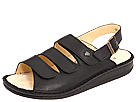

In [5]:
# show some samples

dataset[0]["image"]

In [6]:
# process

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
def process(samples):

    imgs = [transform(image.convert("RGB")) for image in samples["image"]]
    return {"images": imgs}

In [8]:
dataset.set_transform(process)

In [9]:
dataset[0]["images"].size()

torch.Size([3, 128, 128])

In [10]:
import torch

dataloader = torch.utils.data.DataLoader(dataset, batch_size=24, shuffle=True)

#### 2. load model

In [14]:
# construct unet

from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=128,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [15]:
num_params = 0
for name, param in unet.named_parameters():
    num_params += param.numel()

print(num_params)

113673219


#### 3. Load scheduler

In [16]:
#

from diffusers import DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000)
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.24.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

tensor(-1.) tensor(1.)
torch.Size([3, 128, 128])


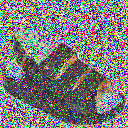

In [17]:
# add noise

import torch
from PIL import Image
from diffusers.utils import make_image_grid

sample = dataset[0]["images"]

print(torch.min(sample), torch.max(sample))

noise_normal = torch.randn(sample.shape)

timestep = torch.tensor([100])

noisy_image = scheduler.add_noise(sample, noise_normal, timestep)

print(noisy_image.shape)

Image.fromarray(((noisy_image.permute(1,2,0) + 1.0) * 127.5).type(torch.uint8).numpy())


#### 4. optimizer & scheduler

In [18]:
# define optimizer

from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader)*50
)


#### 5. eval func

In [19]:
# evaluate

# for diffusion models, the most efficient way to evaluate is to generate images and do visual check

import os
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid

def evaluate(_unet, _scheduler, _epoch, path):
    pipe = DDPMPipeline(_unet, _scheduler)


    images = pipe(batch_size=4, generator=torch.Generator().manual_seed(42)).images

    grid = make_image_grid(images, rows=1, cols=4)

    if not os.path.isdir(path):
        os.mkdir(path)

    grid.save(os.path.join(path, f"{_epoch:04d}.png"))

    


#### 6.train loop

In [75]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train(epochs, _model, _scheduler, _optimizer, _dataloader, _lr_scheduler):

    global_step = 0

    for e in range(epochs):

        progress_bar = tqdm(total=len(_dataloader))

        progress_bar.set_description(f"Epoch {e}")

        for step, batch in enumerate(_dataloader):

            images = batch["images"].to(_model.device)

            noise = torch.randn(images.shape, device=_model.device)

            # sample time steps

            timesteps = torch.randint(0, _scheduler.config.num_train_timesteps, (images.shape[0],), device=_model.device)

            noisy_images = _scheduler.add_noise(images, noise, timesteps)

            noise_pred = _model(noisy_images, timesteps)[0]

            _optimizer.zero_grad()

            loss = F.mse_loss(noise_pred, noise)

            loss.backward()

            _optimizer.step()

            _lr_scheduler.step()

            global_step += 1

            progress_bar.update(1)

            if global_step % 50 == 0:

                print(f"epoch: {e}, step: {global_step}, lr: {_lr_scheduler.get_last_lr()[0]}, loss: {loss.detach().item()}")

        evaluate(_model, _scheduler, e)

In [77]:
# 24GB - batch12 128x128
train(50, unet, scheduler, optimizer, dataloader, lr_scheduler)

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 0, step: 50, lr: 1e-05, loss: 0.004023808520287275
epoch: 0, step: 100, lr: 2e-05, loss: 0.0022093583829700947
epoch: 0, step: 150, lr: 3e-05, loss: 0.009149225428700447


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 1, step: 200, lr: 4e-05, loss: 0.0023191224317997694
epoch: 1, step: 250, lr: 5e-05, loss: 0.0031473843846470118
epoch: 1, step: 300, lr: 6e-05, loss: 0.014420117251574993


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 2, step: 350, lr: 7e-05, loss: 0.003939738031476736
epoch: 2, step: 400, lr: 8e-05, loss: 0.008641001768410206
epoch: 2, step: 450, lr: 9e-05, loss: 0.007720558904111385
epoch: 2, step: 500, lr: 0.0001, loss: 0.003109772689640522


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 3, step: 550, lr: 9.998999018714263e-05, loss: 0.0048576476983726025
epoch: 3, step: 600, lr: 9.995996475642466e-05, loss: 0.0037141807842999697
epoch: 3, step: 650, lr: 9.990993572980378e-05, loss: 0.0030030158814042807


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 4, step: 700, lr: 9.983992313852774e-05, loss: 0.004190657753497362
epoch: 4, step: 750, lr: 9.974995501511404e-05, loss: 0.00438345642760396
epoch: 4, step: 800, lr: 9.964006738212575e-05, loss: 0.0028594299219548702


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 5, step: 850, lr: 9.951030423774859e-05, loss: 0.025147095322608948
epoch: 5, step: 900, lr: 9.936071753817415e-05, loss: 0.007305309176445007
epoch: 5, step: 950, lr: 9.919136717679722e-05, loss: 0.004195728339254856
epoch: 5, step: 1000, lr: 9.900232096023477e-05, loss: 0.002162934048101306


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 6, step: 1050, lr: 9.879365458117678e-05, loss: 0.003517825622111559
epoch: 6, step: 1100, lr: 9.856545158807938e-05, loss: 0.004443966317921877
epoch: 6, step: 1150, lr: 9.831780335171279e-05, loss: 0.001699851593002677


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 7, step: 1200, lr: 9.805080902857699e-05, loss: 0.003953730221837759
epoch: 7, step: 1250, lr: 9.776457552120033e-05, loss: 0.0033303657546639442
epoch: 7, step: 1300, lr: 9.745921743533653e-05, loss: 0.0017292236443609


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 8, step: 1350, lr: 9.713485703407731e-05, loss: 0.005372802261263132
epoch: 8, step: 1400, lr: 9.679162418889931e-05, loss: 0.0021927563939243555
epoch: 8, step: 1450, lr: 9.642965632766436e-05, loss: 0.0033037003595381975
epoch: 8, step: 1500, lr: 9.604909837959455e-05, loss: 0.003092868020758033


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 9, step: 1550, lr: 9.565010271724352e-05, loss: 0.0019007888622581959
epoch: 9, step: 1600, lr: 9.523282909548773e-05, loss: 0.003926560748368502
epoch: 9, step: 1650, lr: 9.47974445875617e-05, loss: 0.0017856569029390812


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 10, step: 1700, lr: 9.434412351816328e-05, loss: 0.006227375473827124
epoch: 10, step: 1750, lr: 9.387304739365523e-05, loss: 0.003493781667202711
epoch: 10, step: 1800, lr: 9.338440482939146e-05, loss: 0.0018698208732530475


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 11, step: 1850, lr: 9.287839147419686e-05, loss: 0.004971091169863939
epoch: 11, step: 1900, lr: 9.2355209932031e-05, loss: 0.005718730855733156
epoch: 11, step: 1950, lr: 9.181506968086697e-05, loss: 0.0043767159804701805
epoch: 11, step: 2000, lr: 9.125818698881798e-05, loss: 0.0036289480049163103


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 12, step: 2050, lr: 9.068478482754532e-05, loss: 0.002369772642850876
epoch: 12, step: 2100, lr: 9.0095092782982e-05, loss: 0.004624090623110533
epoch: 12, step: 2150, lr: 8.948934696340843e-05, loss: 0.004291458986699581


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 13, step: 2200, lr: 8.886778990491631e-05, loss: 0.0019964384846389294
epoch: 13, step: 2250, lr: 8.823067047429907e-05, loss: 0.0026364221703261137
epoch: 13, step: 2300, lr: 8.757824376940746e-05, loss: 0.005062192678451538


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 14, step: 2350, lr: 8.691077101701024e-05, loss: 0.003669536905363202
epoch: 14, step: 2400, lr: 8.622851946820095e-05, loss: 0.00461103580892086
epoch: 14, step: 2450, lr: 8.553176229139261e-05, loss: 0.0027858701068907976
epoch: 14, step: 2500, lr: 8.482077846294308e-05, loss: 0.0025726978201419115


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 15, step: 2550, lr: 8.409585265545509e-05, loss: 0.0009499387815594673
epoch: 15, step: 2600, lr: 8.335727512379534e-05, loss: 0.0033524439204484224
epoch: 15, step: 2650, lr: 8.260534158887876e-05, loss: 0.002093757502734661


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 16, step: 2700, lr: 8.184035311926396e-05, loss: 0.0025689697358757257
epoch: 16, step: 2750, lr: 8.106261601060772e-05, loss: 0.0029330619145184755
epoch: 16, step: 2800, lr: 8.027244166302642e-05, loss: 0.001874422887340188


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 17, step: 2850, lr: 7.947014645641379e-05, loss: 0.00589830381795764
epoch: 17, step: 2900, lr: 7.865605162376486e-05, loss: 0.0029605769086629152
epoch: 17, step: 2950, lr: 7.783048312255653e-05, loss: 0.00383802130818367
epoch: 17, step: 3000, lr: 7.699377150423672e-05, loss: 0.0032890927977859974


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 18, step: 3050, lr: 7.614625178187402e-05, loss: 0.0031487515661865473
epoch: 18, step: 3100, lr: 7.528826329602099e-05, loss: 0.001437387545593083
epoch: 18, step: 3150, lr: 7.442014957884472e-05, loss: 0.003267373889684677


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 19, step: 3200, lr: 7.354225821657914e-05, loss: 0.0023754623252898455
epoch: 19, step: 3250, lr: 7.265494071035401e-05, loss: 0.0010317073902115226
epoch: 19, step: 3300, lr: 7.175855233545668e-05, loss: 0.0034876384306699038


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 20, step: 3350, lr: 7.085345199908235e-05, loss: 0.0021914478857070208
epoch: 20, step: 3400, lr: 6.994000209663036e-05, loss: 0.015087244100868702
epoch: 20, step: 3450, lr: 6.901856836660386e-05, loss: 0.001735364319756627
epoch: 20, step: 3500, lr: 6.808951974417078e-05, loss: 0.002897498430684209


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 21, step: 3550, lr: 6.715322821344494e-05, loss: 0.00432397797703743
epoch: 21, step: 3600, lr: 6.621006865854644e-05, loss: 0.015565620735287666
epoch: 21, step: 3650, lr: 6.526041871350086e-05, loss: 0.004084887448698282


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 22, step: 3700, lr: 6.43046586110374e-05, loss: 0.0052827829495072365
epoch: 22, step: 3750, lr: 6.334317103034652e-05, loss: 0.0033829922322183847
epoch: 22, step: 3800, lr: 6.237634094385813e-05, loss: 0.0029368610121309757


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 23, step: 3850, lr: 6.140455546310148e-05, loss: 0.0035052623134106398
epoch: 23, step: 3900, lr: 6.042820368370854e-05, loss: 0.002878245897591114
epoch: 23, step: 3950, lr: 5.944767652962309e-05, loss: 0.0011440423550084233
epoch: 23, step: 4000, lr: 5.8463366596577706e-05, loss: 0.0023891932796686888


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 24, step: 4050, lr: 5.747566799490132e-05, loss: 0.004217479377985001
epoch: 24, step: 4100, lr: 5.648497619172042e-05, loss: 0.002882807282730937
epoch: 24, step: 4150, lr: 5.549168785261698e-05, loss: 0.003510341513901949


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 25, step: 4200, lr: 5.4496200682806495e-05, loss: 0.001860057353042066
epoch: 25, step: 4250, lr: 5.3498913267899864e-05, loss: 0.0036310574505478144
epoch: 25, step: 4300, lr: 5.250022491431259e-05, loss: 0.002181778894737363


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 26, step: 4350, lr: 5.150053548938557e-05, loss: 0.004971661139279604
epoch: 26, step: 4400, lr: 5.0500245261281175e-05, loss: 0.0030167477671056986
epoch: 26, step: 4450, lr: 4.949975473871884e-05, loss: 0.008063489571213722
epoch: 26, step: 4500, lr: 4.849946451061443e-05, loss: 0.003984655719250441


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 27, step: 4550, lr: 4.749977508568742e-05, loss: 0.00172118516638875
epoch: 27, step: 4600, lr: 4.650108673210015e-05, loss: 0.0026108347810804844
epoch: 27, step: 4650, lr: 4.550379931719351e-05, loss: 0.0024791054893285036


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 28, step: 4700, lr: 4.4508312147383036e-05, loss: 0.0019798483699560165
epoch: 28, step: 4750, lr: 4.3515023808279586e-05, loss: 0.0027697242330759764
epoch: 28, step: 4800, lr: 4.252433200509869e-05, loss: 0.002528676763176918


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 29, step: 4850, lr: 4.1536633403422306e-05, loss: 0.0006726941210217774
epoch: 29, step: 4900, lr: 4.0552323470376916e-05, loss: 0.006126797292381525
epoch: 29, step: 4950, lr: 3.9571796316291476e-05, loss: 0.002073964336887002
epoch: 29, step: 5000, lr: 3.859544453689853e-05, loss: 0.003547598607838154


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 30, step: 5050, lr: 3.762365905614187e-05, loss: 0.001493936637416482
epoch: 30, step: 5100, lr: 3.665682896965349e-05, loss: 0.0033474445808678865
epoch: 30, step: 5150, lr: 3.5695341388962614e-05, loss: 0.0014899892266839743


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 31, step: 5200, lr: 3.473958128649915e-05, loss: 0.003554744878783822
epoch: 31, step: 5250, lr: 3.378993134145356e-05, loss: 0.002046076348051429
epoch: 31, step: 5300, lr: 3.284677178655507e-05, loss: 0.012081748805940151


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 32, step: 5350, lr: 3.1910480255829237e-05, loss: 0.004094555042684078
epoch: 32, step: 5400, lr: 3.098143163339615e-05, loss: 0.003129533724859357
epoch: 32, step: 5450, lr: 3.0059997903369656e-05, loss: 0.0023272805847227573
epoch: 32, step: 5500, lr: 2.914654800091768e-05, loss: 0.0013828581431880593


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 33, step: 5550, lr: 2.824144766454333e-05, loss: 0.009524312801659107
epoch: 33, step: 5600, lr: 2.7345059289646008e-05, loss: 0.005288563668727875
epoch: 33, step: 5650, lr: 2.6457741783420886e-05, loss: 0.0022089651320129633


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 34, step: 5700, lr: 2.5579850421155293e-05, loss: 0.002977340715005994
epoch: 34, step: 5750, lr: 2.4711736703979018e-05, loss: 0.0026191724464297295
epoch: 34, step: 5800, lr: 2.3853748218126e-05, loss: 0.003511993447318673


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 35, step: 5850, lr: 2.3006228495763295e-05, loss: 0.0015137310838326812
epoch: 35, step: 5900, lr: 2.2169516877443485e-05, loss: 0.002343478612601757
epoch: 35, step: 5950, lr: 2.1343948376235144e-05, loss: 0.0013844674685969949
epoch: 35, step: 6000, lr: 2.052985354358622e-05, loss: 0.0026845745742321014


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 36, step: 6050, lr: 1.9727558336973595e-05, loss: 0.003738373052328825
epoch: 36, step: 6100, lr: 1.8937383989392294e-05, loss: 0.003928220830857754
epoch: 36, step: 6150, lr: 1.8159646880736036e-05, loss: 0.002664389321580529


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 37, step: 6200, lr: 1.739465841112125e-05, loss: 0.0013830781681463122
epoch: 37, step: 6250, lr: 1.664272487620466e-05, loss: 0.004465596750378609
epoch: 37, step: 6300, lr: 1.590414734454493e-05, loss: 0.0031680739484727383


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 38, step: 6350, lr: 1.517922153705692e-05, loss: 0.002943985862657428
epoch: 38, step: 6400, lr: 1.4468237708607397e-05, loss: 0.008119973354041576
epoch: 38, step: 6450, lr: 1.3771480531799052e-05, loss: 0.0023549473844468594
epoch: 38, step: 6500, lr: 1.308922898298977e-05, loss: 0.0018229072447866201


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 39, step: 6550, lr: 1.2421756230592534e-05, loss: 0.0019242221023887396
epoch: 39, step: 6600, lr: 1.1769329525700935e-05, loss: 0.002068607835099101
epoch: 39, step: 6650, lr: 1.1132210095083694e-05, loss: 0.002357658464461565


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 40, step: 6700, lr: 1.0510653036591583e-05, loss: 0.006417193915694952
epoch: 40, step: 6750, lr: 9.904907217018e-06, loss: 0.0011847023852169514
epoch: 40, step: 6800, lr: 9.31521517245469e-06, loss: 0.0046408940106630325


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 41, step: 6850, lr: 8.741813011182014e-06, loss: 0.00113067461643368
epoch: 41, step: 6900, lr: 8.18493031913305e-06, loss: 0.004164327867329121
epoch: 41, step: 6950, lr: 7.644790067969005e-06, loss: 0.0017493776977062225
epoch: 41, step: 7000, lr: 7.1216085258031414e-06, loss: 0.008158703334629536


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 42, step: 7050, lr: 6.6155951706085405e-06, loss: 0.00169690465554595
epoch: 42, step: 7100, lr: 6.1269526063447765e-06, loss: 0.001204508007504046
epoch: 42, step: 7150, lr: 5.6558764818367195e-06, loss: 0.006253789644688368


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 43, step: 7200, lr: 5.2025554124383095e-06, loss: 0.00246437662281096
epoch: 43, step: 7250, lr: 4.767170904512292e-06, loss: 0.0020271395333111286
epoch: 43, step: 7300, lr: 4.349897282756487e-06, loss: 0.003921103663742542


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 44, step: 7350, lr: 3.95090162040545e-06, loss: 0.004442410543560982
epoch: 44, step: 7400, lr: 3.570343672335641e-06, loss: 0.004747365135699511
epoch: 44, step: 7450, lr: 3.2083758111006945e-06, loss: 0.004077518358826637
epoch: 44, step: 7500, lr: 2.86514296592269e-06, loss: 0.004509943071752787


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 45, step: 7550, lr: 2.54078256466348e-06, loss: 0.0010098774218931794
epoch: 45, step: 7600, lr: 2.2354244787996748e-06, loss: 0.007352317217737436
epoch: 45, step: 7650, lr: 1.9491909714230204e-06, loss: 0.0018383389106020331


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 46, step: 7700, lr: 1.6821966482872264e-06, loss: 0.0013755859108641744
epoch: 46, step: 7750, lr: 1.434548411920622e-06, loss: 0.03728281706571579
epoch: 46, step: 7800, lr: 1.206345418823235e-06, loss: 0.006295166909694672


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 47, step: 7850, lr: 9.976790397652315e-07, loss: 0.0036269149277359247
epoch: 47, step: 7900, lr: 8.086328232027873e-07, loss: 0.004776539746671915
epoch: 47, step: 7950, lr: 6.392824618258519e-07, loss: 0.0012697628699243069
epoch: 47, step: 8000, lr: 4.896957622514298e-07, loss: 0.0023609623312950134


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 48, step: 8050, lr: 3.599326178742535e-07, loss: 0.0035493888426572084
epoch: 48, step: 8100, lr: 2.500449848859776e-07, loss: 0.002508960198611021
epoch: 48, step: 8150, lr: 1.6007686147225254e-07, loss: 0.0015012326184660196


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

epoch: 49, step: 8200, lr: 9.006427019622176e-08, loss: 0.0012527768267318606
epoch: 49, step: 8250, lr: 4.0035243575342605e-08, loss: 0.0012389139737933874
epoch: 49, step: 8300, lr: 1.0009812857370016e-08, loss: 0.0025025042705237865
epoch: 49, step: 8350, lr: 0.0, loss: 0.0009575149742886424


  0%|          | 0/1000 [00:00<?, ?it/s]

#### 6. Inference

In [ ]:
# pipeline

pipe = DDPMPipeline(unet, scheduler)
images = pipe(batch_size=4, num_inference_steps=1000).images
make_image_grid(images, cols=4, rows=1)

: 

### using pretrained model

In [1]:
from diffusers import UNet2DModel, DDPMScheduler, DiffusionPipeline


# load unet
# unet_p = UNet2DModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)
unet_p = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet").to(device)

# load scheduler
scheduler_p = DDPMScheduler.from_pretrained("CompVis/ldm-celebahq-256", subfolder="scheduler")

# define optimizer
optimizer = torch.optim.Adam(unet_p.parameters(), lr=1e-4)


/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

KeyboardInterrupt



In [ ]:
# 24G
train(50, unet_p, scheduler_p, optimizer, dataloader)

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 0, step: 100, loss: 0.0008148807683028281
epoch: 0, step: 200, loss: 0.0036393541377037764
epoch: 0, step: 300, loss: 0.0037260428071022034


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 1, step: 400, loss: 0.002067781053483486
epoch: 1, step: 500, loss: 0.001589913503266871
epoch: 1, step: 600, loss: 0.005813917610794306


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 2, step: 700, loss: 0.00367742870002985
epoch: 2, step: 800, loss: 0.006692081689834595
epoch: 2, step: 900, loss: 0.0012932992540299892


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 3, step: 1000, loss: 0.0012308997102081776
epoch: 3, step: 1100, loss: 0.0037369050551205873
epoch: 3, step: 1200, loss: 0.0012122371699661016
epoch: 3, step: 1300, loss: 0.00301930564455688


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 4, step: 1400, loss: 0.002939905971288681
epoch: 4, step: 1500, loss: 0.004039813298732042
epoch: 4, step: 1600, loss: 0.0018035511020570993


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 5, step: 1700, loss: 0.0023418606724590063
epoch: 5, step: 1800, loss: 0.004659839905798435
epoch: 5, step: 1900, loss: 0.0018720655934885144


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 6, step: 2000, loss: 0.0016997518250718713
epoch: 6, step: 2100, loss: 0.004258025903254747
epoch: 6, step: 2200, loss: 0.0034160600043833256
epoch: 6, step: 2300, loss: 0.0005761401844210923


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 7, step: 2400, loss: 0.003410374280065298
epoch: 7, step: 2500, loss: 0.004640241619199514
epoch: 7, step: 2600, loss: 0.013793150894343853


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 8, step: 2700, loss: 0.002636696444824338
epoch: 8, step: 2800, loss: 0.003898728173226118
epoch: 8, step: 2900, loss: 0.0018238563789054751


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 9, step: 3000, loss: 0.0024301749654114246
epoch: 9, step: 3100, loss: 0.00172319239936769
epoch: 9, step: 3200, loss: 0.002882307628169656
epoch: 9, step: 3300, loss: 0.007821068167686462


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 10, step: 3400, loss: 0.004099488258361816
epoch: 10, step: 3500, loss: 0.004754857625812292
epoch: 10, step: 3600, loss: 0.002689387183636427


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 11, step: 3700, loss: 0.0010700129205361009
epoch: 11, step: 3800, loss: 0.001377249602228403
epoch: 11, step: 3900, loss: 1.00151526927948


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 12, step: 4000, loss: 1.0006464719772339
epoch: 12, step: 4100, loss: 0.9993532299995422
epoch: 12, step: 4200, loss: 1.0011757612228394
epoch: 12, step: 4300, loss: 1.0014021396636963


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 13, step: 4400, loss: 0.9998957514762878
epoch: 13, step: 4500, loss: 1.0024744272232056
epoch: 13, step: 4600, loss: 0.9928129315376282


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 14, step: 4700, loss: 0.9906230568885803
epoch: 14, step: 4800, loss: 0.9918785095214844
epoch: 14, step: 4900, loss: 1.0036426782608032


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 15, step: 5000, loss: 0.981781005859375
epoch: 15, step: 5100, loss: 0.9751266837120056
epoch: 15, step: 5200, loss: 0.9928616285324097
epoch: 15, step: 5300, loss: 0.9911062717437744


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 16, step: 5400, loss: 0.9954189658164978
epoch: 16, step: 5500, loss: 0.9829033017158508
epoch: 16, step: 5600, loss: 0.9515392780303955


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 17, step: 5700, loss: 0.998770534992218
epoch: 17, step: 5800, loss: 0.9921849370002747
epoch: 17, step: 5900, loss: 0.9922358393669128


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 18, step: 6000, loss: 0.9429088234901428
epoch: 18, step: 6100, loss: 1.002170443534851
epoch: 18, step: 6200, loss: 0.9992192387580872
epoch: 18, step: 6300, loss: 0.9982738494873047


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 19, step: 6400, loss: 0.9947393536567688
epoch: 19, step: 6500, loss: 0.9192225337028503
epoch: 19, step: 6600, loss: 1.0061928033828735


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 20, step: 6700, loss: 0.9971413016319275
epoch: 20, step: 6800, loss: 1.0024065971374512
epoch: 20, step: 6900, loss: 1.0014822483062744


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 21, step: 7000, loss: 0.9947698712348938
epoch: 21, step: 7100, loss: 0.9964087605476379
epoch: 21, step: 7200, loss: 0.9937174916267395
epoch: 21, step: 7300, loss: 0.9982520341873169


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 22, step: 7400, loss: 0.9974285960197449
epoch: 22, step: 7500, loss: 0.9923214316368103
epoch: 22, step: 7600, loss: 0.9947171807289124


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 23, step: 7700, loss: 0.9922528862953186
epoch: 23, step: 7800, loss: 0.9844492673873901
epoch: 23, step: 7900, loss: 0.9896885752677917


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 24, step: 8000, loss: 0.9870907664299011
epoch: 24, step: 8100, loss: 0.9870143532752991
epoch: 24, step: 8200, loss: 0.9788203835487366
epoch: 24, step: 8300, loss: 1.0018194913864136


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 25, step: 8400, loss: 0.9711426496505737
epoch: 25, step: 8500, loss: 1.0057692527770996
epoch: 25, step: 8600, loss: 0.9987167716026306


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 26, step: 8700, loss: 0.9877777099609375
epoch: 26, step: 8800, loss: 0.95143061876297
epoch: 26, step: 8900, loss: 0.9960744976997375


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 27, step: 9000, loss: 0.9960291385650635
epoch: 27, step: 9100, loss: 1.0010850429534912
epoch: 27, step: 9200, loss: 0.9968565702438354
epoch: 27, step: 9300, loss: 1.0028016567230225


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 28, step: 9400, loss: 1.0003201961517334
epoch: 28, step: 9500, loss: 0.9933567047119141
epoch: 28, step: 9600, loss: 0.9955611824989319


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 29, step: 9700, loss: 0.9989111423492432
epoch: 29, step: 9800, loss: 0.9999281764030457
epoch: 29, step: 9900, loss: 0.9998772740364075


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 30, step: 10000, loss: 0.9976195096969604
epoch: 30, step: 10100, loss: 0.9877837300300598
epoch: 30, step: 10200, loss: 0.9875545501708984
epoch: 30, step: 10300, loss: 0.9898868203163147


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 31, step: 10400, loss: 0.9869428277015686
epoch: 31, step: 10500, loss: 0.9800244569778442
epoch: 31, step: 10600, loss: 0.9902155995368958


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 32, step: 10700, loss: 0.933864414691925
epoch: 32, step: 10800, loss: 1.000956416130066
epoch: 32, step: 10900, loss: 1.0012792348861694


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 33, step: 11000, loss: 0.9983535408973694
epoch: 33, step: 11100, loss: 0.9997614026069641
epoch: 33, step: 11200, loss: 0.9996007084846497
epoch: 33, step: 11300, loss: 0.9990242123603821


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 34, step: 11400, loss: 0.9979144334793091
epoch: 34, step: 11500, loss: 0.9944663643836975
epoch: 34, step: 11600, loss: 0.9983342289924622


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 35, step: 11700, loss: 0.9995598196983337
epoch: 35, step: 11800, loss: 1.0046395063400269
epoch: 35, step: 11900, loss: 1.00178062915802


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 36, step: 12000, loss: 1.001355767250061
epoch: 36, step: 12100, loss: 0.9986231923103333
epoch: 36, step: 12200, loss: 0.9940575361251831
epoch: 36, step: 12300, loss: 0.9986165165901184


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 37, step: 12400, loss: 0.9926151633262634
epoch: 37, step: 12500, loss: 0.9909042716026306
epoch: 37, step: 12600, loss: 0.9923062920570374


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 38, step: 12700, loss: 0.9918661117553711
epoch: 38, step: 12800, loss: 0.9880218505859375
epoch: 38, step: 12900, loss: 0.9876924157142639


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 39, step: 13000, loss: 0.9860897064208984
epoch: 39, step: 13100, loss: 0.9841631054878235
epoch: 39, step: 13200, loss: 0.9893601536750793
epoch: 39, step: 13300, loss: 0.9873952865600586


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 40, step: 13400, loss: 0.9869306683540344
epoch: 40, step: 13500, loss: 0.9828742146492004
epoch: 40, step: 13600, loss: 0.9852268695831299


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 41, step: 13700, loss: 0.9804969429969788
epoch: 41, step: 13800, loss: 0.9844116568565369
epoch: 41, step: 13900, loss: 0.9748085737228394


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 42, step: 14000, loss: 0.9476057887077332
epoch: 42, step: 14100, loss: 0.9925982356071472
epoch: 42, step: 14200, loss: 0.9891285300254822
epoch: 42, step: 14300, loss: 0.9910290837287903


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 43, step: 14400, loss: 0.9890047907829285
epoch: 43, step: 14500, loss: 0.9770882725715637
epoch: 43, step: 14600, loss: 0.9820953011512756


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 44, step: 14700, loss: 0.9653645753860474
epoch: 44, step: 14800, loss: 0.9591911435127258
epoch: 44, step: 14900, loss: 0.9326916933059692


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 45, step: 15000, loss: 0.903593897819519
epoch: 45, step: 15100, loss: 0.9956662058830261
epoch: 45, step: 15200, loss: 0.9944021701812744
epoch: 45, step: 15300, loss: 0.9909603595733643


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 46, step: 15400, loss: 0.9886467456817627
epoch: 46, step: 15500, loss: 0.9563838243484497
epoch: 46, step: 15600, loss: 0.9294042587280273


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 47, step: 15700, loss: 0.924302875995636
epoch: 47, step: 15800, loss: 0.9250938892364502
epoch: 47, step: 15900, loss: 0.8527395129203796


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 48, step: 16000, loss: 0.8447586894035339
epoch: 48, step: 16100, loss: 1.0029182434082031
epoch: 48, step: 16200, loss: 0.9963961839675903
epoch: 48, step: 16300, loss: 0.9996041059494019


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

epoch: 49, step: 16400, loss: 0.9962003827095032
epoch: 49, step: 16500, loss: 0.994556725025177
epoch: 49, step: 16600, loss: 0.9883942008018494


  0%|          | 0/1000 [00:00<?, ?it/s]

### accelerator

In [25]:
from tqdm import tqdm
import torch.nn.functional as F
from accelerate import Accelerator

def train(epochs, _model, _scheduler, _optimizer, _dataloader, lr_scheduler):

    _model = _model.to(device)

    global_step = 0

    accelerator = Accelerator(log_with="tensorboard", 
                              mixed_precision="fp16",
                              gradient_accumulation_steps=8,
                              project_dir="./tmp/checkpoints")


    # wrap to accelerate
    _model, _optimizer, _dataloader, lr_scheduler = accelerator.prepare(_model, _optimizer, _dataloader, lr_scheduler)

    # init tracker
    accelerator.init_trackers("train")
    

    for e in range(epochs):

        _model.train()
        
        progress_bar = tqdm(total=len(_dataloader))

        progress_bar.set_description(f"Epoch {e}")

        for step, batch in enumerate(_dataloader):

            images = batch["images"].to(_model.device)

            noise = torch.randn(images.shape, device=_model.device)

            # sample time steps

            timesteps = torch.randint(0, _scheduler.config.num_train_timesteps, (images.shape[0],), device=_model.device)

            noisy_images = _scheduler.add_noise(images, noise, timesteps)

            with accelerator.accumulate(_model):

                noise_pred = _model(noisy_images, timesteps)[0]

                _optimizer.zero_grad()

                loss = F.mse_loss(noise_pred, noise)

                accelerator.backward(loss)

                _optimizer.step()

                lr_scheduler.step()

                if accelerator.sync_gradients:
                    
                    global_step += 1

                    progress_bar.update(1)

                    if global_step % 20 == 0:
                        accelerator.print(f"epoch: {e}, step: {global_step},  lr: {lr_scheduler.get_last_lr()[0]:.4g}, loss: {loss.detach().cpu():.4g}")
                        accelerator.log({"loss": loss.detach().item()}, global_step)


            if accelerator.is_main_process:

                if global_step % 20 == 0:
                    path = "./tmp/shoes_model1"
                    evaluate(accelerator.unwrap_model(_model), _scheduler, global_step, path)
                    
                    pipe = DDPMPipeline(accelerator.unwrap_model(_model), _scheduler)
                    pipe.save_pretrained(path + f"/pretrain_step_{global_step}")

                    accelerator.save_state(path + f"/state_step_{global_step}")

    Accelerator.end_training()


In [26]:
train(300, unet, scheduler, optimizer, dataloader, lr_scheduler)

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0, step: 20,  lr: 1.2e-05, loss: 0.4491


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 1, step: 40,  lr: 1.6e-05, loss: 0.3265


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 2, step: 60,  lr: 2e-05, loss: 0.149


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 2, step: 80,  lr: 2.4e-05, loss: 0.08674


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 3, step: 100,  lr: 2.8e-05, loss: 0.09549


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 4, step: 120,  lr: 3.2e-05, loss: 0.09543


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 5, step: 140,  lr: 3.6e-05, loss: 0.06817


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 5, step: 160,  lr: 4e-05, loss: 0.08376


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 6, step: 180,  lr: 4.4e-05, loss: 0.0511


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 7, step: 200,  lr: 4.8e-05, loss: 0.04002


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 8, step: 220,  lr: 5.2e-05, loss: 0.06987


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 8, step: 240,  lr: 5.6e-05, loss: 0.04489


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 9, step: 260,  lr: 6e-05, loss: 0.04495


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 10, step: 280,  lr: 6.4e-05, loss: 0.0234


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 11, step: 300,  lr: 6.8e-05, loss: 0.07119


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 11, step: 320,  lr: 7.2e-05, loss: 0.05775


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 12, step: 340,  lr: 7.6e-05, loss: 0.03111


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 13, step: 360,  lr: 8e-05, loss: 0.02056


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 14, step: 380,  lr: 8.4e-05, loss: 0.04973


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 14, step: 400,  lr: 8.8e-05, loss: 0.03336


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 15, step: 420,  lr: 9.2e-05, loss: 0.02852


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 16, step: 440,  lr: 9.6e-05, loss: 0.02613


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 17, step: 460,  lr: 0.0001, loss: 0.02385


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 17, step: 480,  lr: 0.0001, loss: 0.02025


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 18, step: 500,  lr: 0.0001, loss: 0.01494


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 19, step: 520,  lr: 9.999e-05, loss: 0.02742


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 19, step: 540,  lr: 9.998e-05, loss: 0.01582


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 20, step: 560,  lr: 9.998e-05, loss: 0.02159


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 21, step: 580,  lr: 9.996e-05, loss: 0.02703


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 22, step: 600,  lr: 9.995e-05, loss: 0.01538


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 22, step: 620,  lr: 9.994e-05, loss: 0.01701


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 23, step: 640,  lr: 9.992e-05, loss: 0.01667


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 24, step: 660,  lr: 9.99e-05, loss: 0.01702


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 25, step: 680,  lr: 9.988e-05, loss: 0.01899


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 25, step: 700,  lr: 9.986e-05, loss: 0.01392


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 26, step: 720,  lr: 9.983e-05, loss: 0.013


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 27, step: 740,  lr: 9.98e-05, loss: 0.01411


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 28, step: 760,  lr: 9.978e-05, loss: 0.01384


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 28, step: 780,  lr: 9.975e-05, loss: 0.01302


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 29, step: 800,  lr: 9.971e-05, loss: 0.02071


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 30, step: 820,  lr: 9.968e-05, loss: 0.01757


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 31, step: 840,  lr: 9.964e-05, loss: 0.01469


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 31, step: 860,  lr: 9.96e-05, loss: 0.01862


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 32, step: 880,  lr: 9.956e-05, loss: 0.01562


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 33, step: 900,  lr: 9.952e-05, loss: 0.01439


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 34, step: 920,  lr: 9.947e-05, loss: 0.02231


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 34, step: 940,  lr: 9.943e-05, loss: 0.01562


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 35, step: 960,  lr: 9.938e-05, loss: 0.02832


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 36, step: 980,  lr: 9.933e-05, loss: 0.01871


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 37, step: 1000,  lr: 9.928e-05, loss: 0.009094


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 37, step: 1020,  lr: 9.922e-05, loss: 0.02179


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 38, step: 1040,  lr: 9.916e-05, loss: 0.0182


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 39, step: 1060,  lr: 9.911e-05, loss: 0.01273


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 39, step: 1080,  lr: 9.905e-05, loss: 0.03085


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 40, step: 1100,  lr: 9.898e-05, loss: 0.01598


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 41, step: 1120,  lr: 9.892e-05, loss: 0.01515


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 42, step: 1140,  lr: 9.885e-05, loss: 0.009825


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 42, step: 1160,  lr: 9.878e-05, loss: 0.01332


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 43, step: 1180,  lr: 9.871e-05, loss: 0.0221


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 44, step: 1200,  lr: 9.864e-05, loss: 0.01445


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 45, step: 1220,  lr: 9.857e-05, loss: 0.007317


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 45, step: 1240,  lr: 9.849e-05, loss: 0.02066


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 46, step: 1260,  lr: 9.841e-05, loss: 0.01448


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 47, step: 1280,  lr: 9.833e-05, loss: 0.0253


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 48, step: 1300,  lr: 9.825e-05, loss: 0.00753


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 48, step: 1320,  lr: 9.817e-05, loss: 0.01682


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 49, step: 1340,  lr: 9.808e-05, loss: 0.01879


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 50, step: 1360,  lr: 9.799e-05, loss: 0.01762


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 51, step: 1380,  lr: 9.791e-05, loss: 0.009406


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 51, step: 1400,  lr: 9.781e-05, loss: 0.01555


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 52, step: 1420,  lr: 9.772e-05, loss: 0.03511


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 53, step: 1440,  lr: 9.763e-05, loss: 0.01584


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 54, step: 1460,  lr: 9.753e-05, loss: 0.01241


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 54, step: 1480,  lr: 9.743e-05, loss: 0.005979


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 55, step: 1500,  lr: 9.733e-05, loss: 0.01865


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 56, step: 1520,  lr: 9.723e-05, loss: 0.05155


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 57, step: 1540,  lr: 9.712e-05, loss: 0.01809


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 57, step: 1560,  lr: 9.701e-05, loss: 0.009228


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 58, step: 1580,  lr: 9.691e-05, loss: 0.01219


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 59, step: 1600,  lr: 9.68e-05, loss: 0.009772


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 59, step: 1620,  lr: 9.668e-05, loss: 0.01279


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 60, step: 1640,  lr: 9.657e-05, loss: 0.02078


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 61, step: 1660,  lr: 9.645e-05, loss: 0.02302


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 62, step: 1680,  lr: 9.634e-05, loss: 0.006204


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 62, step: 1700,  lr: 9.622e-05, loss: 0.01263


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 63, step: 1720,  lr: 9.61e-05, loss: 0.02196


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 64, step: 1740,  lr: 9.597e-05, loss: 0.02286


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 65, step: 1760,  lr: 9.585e-05, loss: 0.01003


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 65, step: 1780,  lr: 9.572e-05, loss: 0.01006


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 66, step: 1800,  lr: 9.559e-05, loss: 0.0103


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 67, step: 1820,  lr: 9.546e-05, loss: 0.01323


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 68, step: 1840,  lr: 9.533e-05, loss: 0.009003


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 68, step: 1860,  lr: 9.519e-05, loss: 0.01599


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 69, step: 1880,  lr: 9.506e-05, loss: 0.01479


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 70, step: 1900,  lr: 9.492e-05, loss: 0.02538


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 71, step: 1920,  lr: 9.478e-05, loss: 0.009419


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 71, step: 1940,  lr: 9.464e-05, loss: 0.007836


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 72, step: 1960,  lr: 9.45e-05, loss: 0.0231


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 73, step: 1980,  lr: 9.435e-05, loss: 0.006995


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 74, step: 2000,  lr: 9.42e-05, loss: 0.0166


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 74, step: 2020,  lr: 9.406e-05, loss: 0.005437


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 75, step: 2040,  lr: 9.391e-05, loss: 0.008712


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 76, step: 2060,  lr: 9.375e-05, loss: 0.01137


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 77, step: 2080,  lr: 9.36e-05, loss: 0.01314


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 77, step: 2100,  lr: 9.345e-05, loss: 0.04086


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 78, step: 2120,  lr: 9.329e-05, loss: 0.01295


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 79, step: 2140,  lr: 9.313e-05, loss: 0.01532


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 79, step: 2160,  lr: 9.297e-05, loss: 0.006821


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 80, step: 2180,  lr: 9.281e-05, loss: 0.01941


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 81, step: 2200,  lr: 9.264e-05, loss: 0.0114


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 82, step: 2220,  lr: 9.248e-05, loss: 0.01922


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 82, step: 2240,  lr: 9.231e-05, loss: 0.008477


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 83, step: 2260,  lr: 9.214e-05, loss: 0.01514


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 84, step: 2280,  lr: 9.197e-05, loss: 0.008885


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 85, step: 2300,  lr: 9.18e-05, loss: 0.01283


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 85, step: 2320,  lr: 9.162e-05, loss: 0.01648


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 86, step: 2340,  lr: 9.145e-05, loss: 0.01022


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 87, step: 2360,  lr: 9.127e-05, loss: 0.01134


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 88, step: 2380,  lr: 9.109e-05, loss: 0.007899


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 88, step: 2400,  lr: 9.091e-05, loss: 0.0201


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 89, step: 2420,  lr: 9.073e-05, loss: 0.01426


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 90, step: 2440,  lr: 9.054e-05, loss: 0.01012


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 91, step: 2460,  lr: 9.036e-05, loss: 0.01755


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 91, step: 2480,  lr: 9.017e-05, loss: 0.01419


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 92, step: 2500,  lr: 8.998e-05, loss: 0.006499


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 93, step: 2520,  lr: 8.979e-05, loss: 0.004745


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 94, step: 2540,  lr: 8.96e-05, loss: 0.01509


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 94, step: 2560,  lr: 8.941e-05, loss: 0.009063


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 95, step: 2580,  lr: 8.921e-05, loss: 0.006673


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 96, step: 2600,  lr: 8.901e-05, loss: 0.008004


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 97, step: 2620,  lr: 8.882e-05, loss: 0.008615


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 97, step: 2640,  lr: 8.862e-05, loss: 0.01768


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 98, step: 2660,  lr: 8.841e-05, loss: 0.0122


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 99, step: 2680,  lr: 8.821e-05, loss: 0.01126


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 99, step: 2700,  lr: 8.801e-05, loss: 0.01531


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 100, step: 2720,  lr: 8.78e-05, loss: 0.01182


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 101, step: 2740,  lr: 8.759e-05, loss: 0.01753


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 102, step: 2760,  lr: 8.739e-05, loss: 0.007261


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 102, step: 2780,  lr: 8.717e-05, loss: 0.03005


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 103, step: 2800,  lr: 8.696e-05, loss: 0.006366


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 104, step: 2820,  lr: 8.675e-05, loss: 0.01143


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 105, step: 2840,  lr: 8.653e-05, loss: 0.005183


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 105, step: 2860,  lr: 8.632e-05, loss: 0.01239


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 106, step: 2880,  lr: 8.61e-05, loss: 0.007969


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 107, step: 2900,  lr: 8.588e-05, loss: 0.01811


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 108, step: 2920,  lr: 8.566e-05, loss: 0.008447


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 108, step: 2940,  lr: 8.544e-05, loss: 0.006854


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 109, step: 2960,  lr: 8.522e-05, loss: 0.005977


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 110, step: 2980,  lr: 8.499e-05, loss: 0.01733


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 111, step: 3000,  lr: 8.476e-05, loss: 0.02182


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 111, step: 3020,  lr: 8.454e-05, loss: 0.009412


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 112, step: 3040,  lr: 8.431e-05, loss: 0.01525


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 113, step: 3060,  lr: 8.408e-05, loss: 0.004046


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 114, step: 3080,  lr: 8.385e-05, loss: 0.01283


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 114, step: 3100,  lr: 8.361e-05, loss: 0.007168


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 115, step: 3120,  lr: 8.338e-05, loss: 0.006918


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 116, step: 3140,  lr: 8.314e-05, loss: 0.007557


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 117, step: 3160,  lr: 8.291e-05, loss: 0.01498


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 117, step: 3180,  lr: 8.267e-05, loss: 0.009272


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 118, step: 3200,  lr: 8.243e-05, loss: 0.007634


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 119, step: 3220,  lr: 8.219e-05, loss: 0.02391


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 119, step: 3240,  lr: 8.194e-05, loss: 0.006145


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 120, step: 3260,  lr: 8.17e-05, loss: 0.01916


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 121, step: 3280,  lr: 8.146e-05, loss: 0.006474


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 122, step: 3300,  lr: 8.121e-05, loss: 0.01449


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 122, step: 3320,  lr: 8.096e-05, loss: 0.01085


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 123, step: 3340,  lr: 8.071e-05, loss: 0.01187


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 124, step: 3360,  lr: 8.046e-05, loss: 0.02299


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 125, step: 3380,  lr: 8.021e-05, loss: 0.009618


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 125, step: 3400,  lr: 7.996e-05, loss: 0.008247


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 126, step: 3420,  lr: 7.971e-05, loss: 0.01919


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 127, step: 3440,  lr: 7.945e-05, loss: 0.00913


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 128, step: 3460,  lr: 7.92e-05, loss: 0.02173


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 128, step: 3480,  lr: 7.894e-05, loss: 0.01166


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 129, step: 3500,  lr: 7.868e-05, loss: 0.01206


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 130, step: 3520,  lr: 7.842e-05, loss: 0.01384


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 131, step: 3540,  lr: 7.816e-05, loss: 0.01045


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 131, step: 3560,  lr: 7.79e-05, loss: 0.009782


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 132, step: 3580,  lr: 7.764e-05, loss: 0.005766


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 133, step: 3600,  lr: 7.738e-05, loss: 0.01042


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 134, step: 3620,  lr: 7.711e-05, loss: 0.01487


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 134, step: 3640,  lr: 7.684e-05, loss: 0.007378


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 135, step: 3660,  lr: 7.658e-05, loss: 0.01259


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 136, step: 3680,  lr: 7.631e-05, loss: 0.004876


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 137, step: 3700,  lr: 7.604e-05, loss: 0.009906


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 137, step: 3720,  lr: 7.577e-05, loss: 0.01571


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 138, step: 3740,  lr: 7.55e-05, loss: 0.01216


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 139, step: 3760,  lr: 7.523e-05, loss: 0.01272


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 139, step: 3780,  lr: 7.495e-05, loss: 0.002669


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 140, step: 3800,  lr: 7.468e-05, loss: 0.01483


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 141, step: 3820,  lr: 7.441e-05, loss: 0.007468


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 142, step: 3840,  lr: 7.413e-05, loss: 0.01001


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 142, step: 3860,  lr: 7.385e-05, loss: 0.01061


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 143, step: 3880,  lr: 7.357e-05, loss: 0.01154


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 144, step: 3900,  lr: 7.33e-05, loss: 0.01241


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 145, step: 3920,  lr: 7.302e-05, loss: 0.01477


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 145, step: 3940,  lr: 7.273e-05, loss: 0.02227


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 146, step: 3960,  lr: 7.245e-05, loss: 0.01892


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 147, step: 3980,  lr: 7.217e-05, loss: 0.006612


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 148, step: 4000,  lr: 7.189e-05, loss: 0.007175


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 148, step: 4020,  lr: 7.16e-05, loss: 0.008095


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 149, step: 4040,  lr: 7.132e-05, loss: 0.009858


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 150, step: 4060,  lr: 7.103e-05, loss: 0.002905


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 151, step: 4080,  lr: 7.074e-05, loss: 0.02783


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 151, step: 4100,  lr: 7.046e-05, loss: 0.017


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 152, step: 4120,  lr: 7.017e-05, loss: 0.02195


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 153, step: 4140,  lr: 6.988e-05, loss: 0.01738


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 154, step: 4160,  lr: 6.959e-05, loss: 0.01164


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 154, step: 4180,  lr: 6.93e-05, loss: 0.01688


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 155, step: 4200,  lr: 6.901e-05, loss: 0.007772


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 156, step: 4220,  lr: 6.871e-05, loss: 0.009061


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 157, step: 4240,  lr: 6.842e-05, loss: 0.008385


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 157, step: 4260,  lr: 6.813e-05, loss: 0.007335


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 158, step: 4280,  lr: 6.783e-05, loss: 0.007865


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 159, step: 4300,  lr: 6.754e-05, loss: 0.007654


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 159, step: 4320,  lr: 6.724e-05, loss: 0.005407


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 160, step: 4340,  lr: 6.694e-05, loss: 0.006721


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 161, step: 4360,  lr: 6.665e-05, loss: 0.008302


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 162, step: 4380,  lr: 6.635e-05, loss: 0.00821


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 162, step: 4400,  lr: 6.605e-05, loss: 0.01447


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 163, step: 4420,  lr: 6.575e-05, loss: 0.01694


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 164, step: 4440,  lr: 6.545e-05, loss: 0.01724


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 165, step: 4460,  lr: 6.515e-05, loss: 0.004124


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 165, step: 4480,  lr: 6.485e-05, loss: 0.009438


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 166, step: 4500,  lr: 6.455e-05, loss: 0.0199


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 167, step: 4520,  lr: 6.424e-05, loss: 0.01864


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 168, step: 4540,  lr: 6.394e-05, loss: 0.004921


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 168, step: 4560,  lr: 6.364e-05, loss: 0.01024


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 169, step: 4580,  lr: 6.333e-05, loss: 0.01335


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 170, step: 4600,  lr: 6.303e-05, loss: 0.008789


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 171, step: 4620,  lr: 6.272e-05, loss: 0.01716


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 171, step: 4640,  lr: 6.242e-05, loss: 0.009607


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 172, step: 4660,  lr: 6.211e-05, loss: 0.01302


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 173, step: 4680,  lr: 6.181e-05, loss: 0.008655


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 174, step: 4700,  lr: 6.15e-05, loss: 0.01504


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 174, step: 4720,  lr: 6.119e-05, loss: 0.01508


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 175, step: 4740,  lr: 6.088e-05, loss: 0.0135


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 176, step: 4760,  lr: 6.058e-05, loss: 0.015


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 177, step: 4780,  lr: 6.027e-05, loss: 0.02042


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 177, step: 4800,  lr: 5.996e-05, loss: 0.01146


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 178, step: 4820,  lr: 5.965e-05, loss: 0.0131


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 179, step: 4840,  lr: 5.934e-05, loss: 0.008255


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 179, step: 4860,  lr: 5.903e-05, loss: 0.003541


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 180, step: 4880,  lr: 5.872e-05, loss: 0.008615


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 181, step: 4900,  lr: 5.841e-05, loss: 0.01823


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 182, step: 4920,  lr: 5.809e-05, loss: 0.009332


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 182, step: 4940,  lr: 5.778e-05, loss: 0.02031


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 183, step: 4960,  lr: 5.747e-05, loss: 0.009905


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 184, step: 4980,  lr: 5.716e-05, loss: 0.006651


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 185, step: 5000,  lr: 5.685e-05, loss: 0.01578


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 185, step: 5020,  lr: 5.653e-05, loss: 0.01643


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 186, step: 5040,  lr: 5.622e-05, loss: 0.003444


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 187, step: 5060,  lr: 5.591e-05, loss: 0.0151


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 188, step: 5080,  lr: 5.559e-05, loss: 0.007474


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 188, step: 5100,  lr: 5.528e-05, loss: 0.01995


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 189, step: 5120,  lr: 5.496e-05, loss: 0.006889


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 190, step: 5140,  lr: 5.465e-05, loss: 0.005306


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 191, step: 5160,  lr: 5.434e-05, loss: 0.006884


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 191, step: 5180,  lr: 5.402e-05, loss: 0.02052


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 192, step: 5200,  lr: 5.371e-05, loss: 0.01328


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 193, step: 5220,  lr: 5.339e-05, loss: 0.01835


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 194, step: 5240,  lr: 5.308e-05, loss: 0.007661


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 194, step: 5260,  lr: 5.276e-05, loss: 0.008481


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 195, step: 5280,  lr: 5.245e-05, loss: 0.004641


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 196, step: 5300,  lr: 5.213e-05, loss: 0.01151


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 197, step: 5320,  lr: 5.182e-05, loss: 0.01309


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 197, step: 5340,  lr: 5.15e-05, loss: 0.006682


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 198, step: 5360,  lr: 5.118e-05, loss: 0.005349


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 199, step: 5380,  lr: 5.087e-05, loss: 0.0126


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 199, step: 5400,  lr: 5.055e-05, loss: 0.001572


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 200, step: 5420,  lr: 5.024e-05, loss: 0.005478


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 201, step: 5440,  lr: 4.992e-05, loss: 0.004057


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 202, step: 5460,  lr: 4.961e-05, loss: 0.01362


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 202, step: 5480,  lr: 4.929e-05, loss: 0.01065


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 203, step: 5500,  lr: 4.897e-05, loss: 0.009459


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 204, step: 5520,  lr: 4.866e-05, loss: 0.01363


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 205, step: 5540,  lr: 4.834e-05, loss: 0.01082


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 205, step: 5560,  lr: 4.803e-05, loss: 0.005545


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 206, step: 5580,  lr: 4.771e-05, loss: 0.006393


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 207, step: 5600,  lr: 4.74e-05, loss: 0.006668


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 208, step: 5620,  lr: 4.708e-05, loss: 0.007245


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 208, step: 5640,  lr: 4.677e-05, loss: 0.01294


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 209, step: 5660,  lr: 4.645e-05, loss: 0.005404


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 210, step: 5680,  lr: 4.614e-05, loss: 0.01571


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 211, step: 5700,  lr: 4.582e-05, loss: 0.005251


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 211, step: 5720,  lr: 4.551e-05, loss: 0.005694


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 212, step: 5740,  lr: 4.519e-05, loss: 0.006299


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 213, step: 5760,  lr: 4.488e-05, loss: 0.01177


  0%|          | 0/1000 [00:00<?, ?it/s]

SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })